In [1]:
import pandas as pd
from datasets import load_dataset

c:\Users\naran\anaconda3\envs\finetune_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
emotion=load_dataset('emotion')

In [3]:
emotion.set_format(type='pandas')

In [4]:
df=emotion['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [5]:
classes=emotion['train'].features['label'].names

In [6]:
df['label_name']=df['label'].apply(lambda x: classes[x])

In [7]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# Data Analysis 

In [8]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Emotion Distribution')

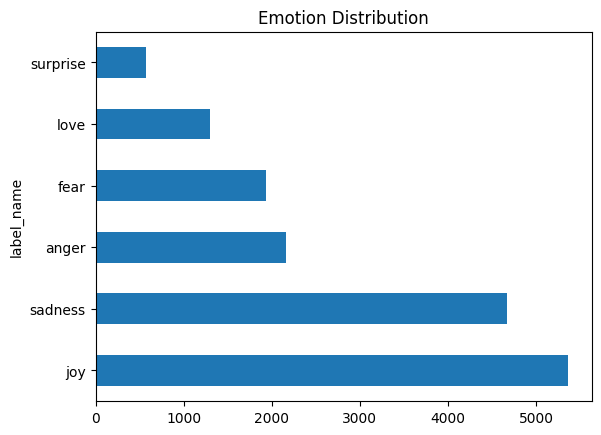

In [9]:
df['label_name'].value_counts().plot.barh()
plt.title('Emotion Distribution')


Here we can see the dataset in imbalaced

<Axes: title={'center': 'Words Per Tweet'}, xlabel='label_name'>

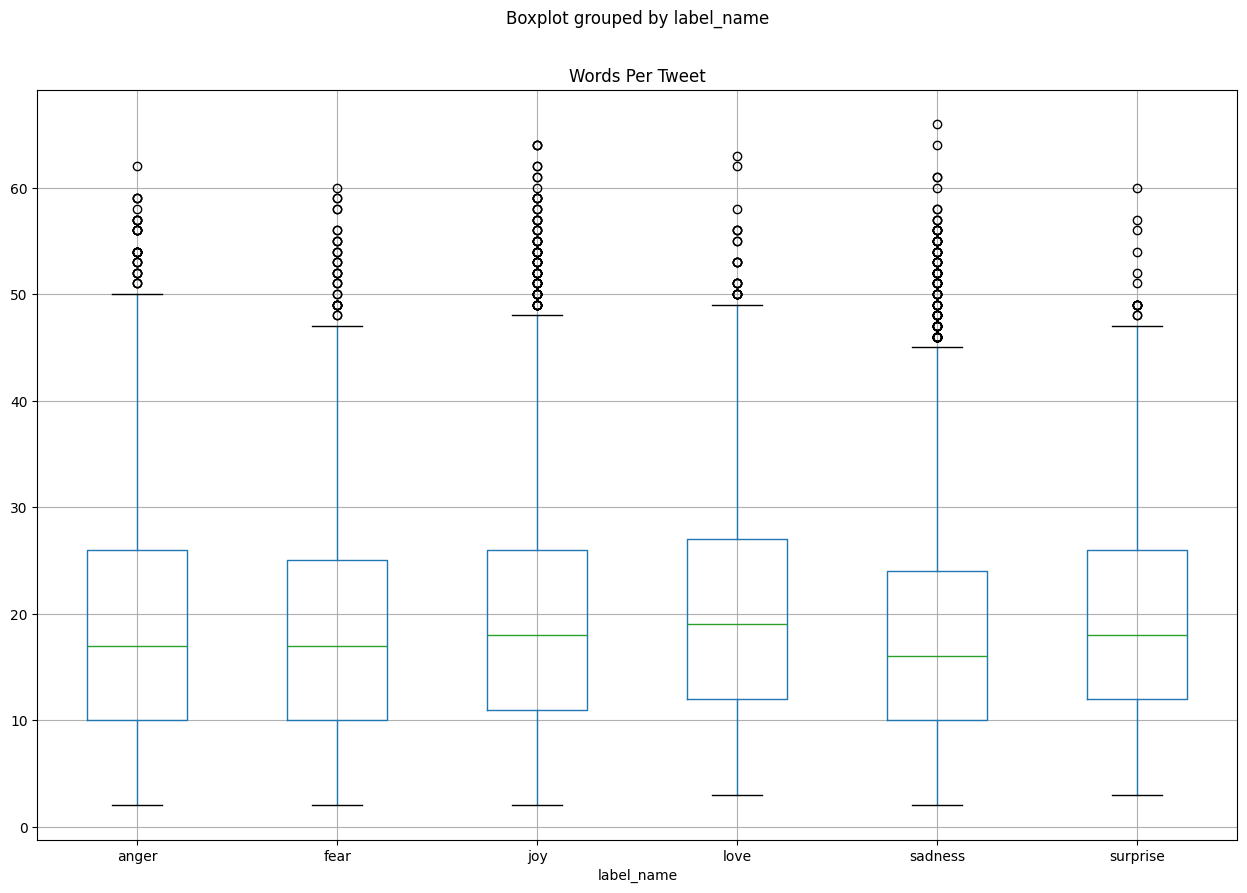

In [10]:
df['Words Per Tweet']=df['text'].str.split().apply(len)
df.boxplot(column='Words Per Tweet',by='label_name',figsize=(15,10))

# Tokenization 

In [11]:
from transformers import AutoTokenizer
model_ckpt='distilbert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

In [12]:
text='I am happy. Tokenization is awesome! I am learning machine learning'
encoded_text=tokenizer(text)
encoded_text

{'input_ids': [101, 1045, 2572, 3407, 1012, 19204, 3989, 2003, 12476, 999, 1045, 2572, 4083, 3698, 4083, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
tokens=tokenizer.convert_ids_to_tokens(encoded_text['input_ids'])
tokens

['[CLS]',
 'i',
 'am',
 'happy',
 '.',
 'token',
 '##ization',
 'is',
 'awesome',
 '!',
 'i',
 'am',
 'learning',
 'machine',
 'learning',
 '[SEP]']

In [14]:
tokenizer.vocab_size, tokenizer.model_max_length    

(30522, 512)

# Tokenization of the Emotion Data

In [15]:
emotion.reset_format()
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [16]:
def tokenize(batch):
    temp=tokenizer(batch['text'],padding=True,truncation=True)
    return temp

print(tokenize(emotion['train'][:5]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2572, 2412, 3110, 16839, 9080, 12863, 2055, 1996, 13788, 1045, 2097, 2113, 2008, 2009, 2003, 2145, 2006, 1996, 3200, 102, 0], [101, 1045, 2572, 3110, 24665, 7140, 11714, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [17]:
emotion_encoded=emotion.map(tokenize,batched=True, batch_size=None)

In [18]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

# Model Building

In [19]:
text

'I am happy. Tokenization is awesome! I am learning machine learning'

In [20]:
inputs=tokenizer(text,return_tensors='pt')
inputs

{'input_ids': tensor([[  101,  1045,  2572,  3407,  1012, 19204,  3989,  2003, 12476,   999,
          1045,  2572,  4083,  3698,  4083,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [21]:
from transformers import AutoModel
import torch 

model = AutoModel.from_pretrained(model_ckpt)

In [22]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [23]:
with torch.no_grad():
    output=model(**inputs)

last_hidden_state=output.last_hidden_state

In [24]:
last_hidden_state.shape

torch.Size([1, 16, 768])

# Fine Tuning the Model

In [25]:
from transformers import AutoModelForSequenceClassification

num_labels=len(classes)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=num_labels).to(device)
device

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device(type='cuda')

In [26]:
from transformers import TrainingArguments

In [27]:
batch_size=64
model_name='distilbert-finetuned-emotion'

traning_args=TrainingArguments(output_dir=model_name,
                                 num_train_epochs=3,learning_rate=2e-5,
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 weight_decay=0.01,
                                 evaluation_strategy='epoch',
                                 disable_tqdm=False)

c:\Users\naran\anaconda3\envs\finetune_env\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
